In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# set working directory - note: all code runs from the src folder
wrk_dir = os.getcwd()
# set data path
data_path = wrk_dir + '\\' + 'data' + '\\'

In [3]:
np.random.seed(2022)

n = 5000
gamma1 = 250
gamma2 = 100
beta1 = 7.5

# exog vars
u1 = gamma1*np.random.normal(loc=0.0, scale=1.0, size=n)
u2 = gamma2*np.random.normal(loc=0.0, scale=1.0, size=n)

# endo vars
x1 = u1
x2 = beta1*x1 + u2

In [4]:
# store data for testing RStan 
d = {'X1': x1,
     'U1': u1,
     'X2': x2,
     'U2': u2
    }
data = pd.DataFrame(d)
data.head(5)

,X1,U1,X2,U2
0,-0.131975,-0.131975,-54.416768,-53.426957
1,-68.725356,-68.725356,-611.367150,-95.926978
2,-34.821390,-34.821390,-272.755678,-11.595250
3,496.171539,496.171539,3962.140328,240.853782
4,70.527331,70.527331,617.738924,88.783938


In [5]:
model = LinearRegression(fit_intercept=True, normalize=False)

x = np.array(data['X1'].copy()).reshape((-1, 1))
print(x.shape)

y = np.array(data['X2'].copy())
print(y.shape)

model.fit(x, y)

print(model.coef_)
print(model.intercept_)

del x, y

(5000, 1)
(5000,)
[7.5024816]
-1.3474952696904055


Under **situation testing** we're constrained by the dataset $\mathcal{D}$, meaning that what we see/have is what we can use. When facing confounding, this limits our approaches: the use of a mediator or instrumental variable(s) will depend on the data in question (here, recall we're in a model-agnostic setting). Now, for SCF we need to retrieve $U$ for the abduction step. This is, at least the Perlian view.

However, I'd add that we also need to *properly identify* the weights of the causal edges. Under confounding, these weights can be biased, which will affect all other steps for SCF. I believe we can frame it as an ommited variable porblem where we are unable to split the residual variance accordingly. This shifts some probability mass into the weights...

In [41]:
beta1

7.5

In [86]:
np.random.seed(2022)

gamma3 = 500
gamma4 = 1
gamma5 = 3

w = gamma3*np.random.normal(loc=0.0, scale=1.75, size=n)
# w = gamma3*np.random.chisquare(df=4, size=n)

# b_u1 = gamma4*w
# b_u2 = gamma5*w
b_u1 = u1 + gamma4*w
b_u2 = u2 + gamma5*w

# endo vars
b_x1 = b_u1
b_x2 = beta1*b_x1 + b_u2
# # endo vars
# b_x1 = u1 + gamma4*w
# b_x2 = beta1*b_x1 + u2 + gamma5*w

In [87]:
# store data for testing RStan 
d2 = {'X1': b_x1,
      'U1': u1,
      'X2': b_x2,
      'U2': u2,
      'W': w
    }
data2 = pd.DataFrame(d2)
data2.head(5)

,X1,U1,X2,U2,W
0,-0.593886,-0.131975,-59.266841,-53.426957,-0.461912
1,-309.264103,-68.725356,-3137.023991,-95.926978,-240.538747
2,-156.696257,-34.821390,-1552.441776,-11.595250,-121.874866
3,2232.771927,496.171539,22196.444402,240.853782,1736.600388
4,317.372991,70.527331,3209.618355,88.783938,246.845660


In [88]:
model2 = LinearRegression(fit_intercept=True, normalize=False)

x = np.array(data2['X1'].copy()).reshape((-1, 1))
print(x.shape)

y = np.array(data2['X2'].copy())
print(y.shape)

model2.fit(x, y)

print(model2.coef_)

print(model2.intercept_)

del x, y

(5000, 1)
(5000,)
[9.8338848]
-1.3474952696904836


In [89]:
model3 = LinearRegression(fit_intercept=True, normalize=False)

x = np.array(data2[['X1', 'W']].copy())#.reshape((-1, 1))
print(x.shape)

y = np.array(data2['X2'].copy())
print(y.shape)

model3.fit(x, y)

print(model3.coef_)

print(model3.intercept_)

del x, y

(5000, 2)
(5000,)
[6.12726668 4.76565186]
-1.347495269690512


It's tricky because even with knowledge of $W$ we can't retrieve $\beta$... focus on more damage control: is it better to do SCF without getting some proxy for $W$ or doing nothing at all? How about recovering $U_2$?

In [90]:
data_u2 = data.copy()

In [91]:
data_u2['hat_u2_unaware'] = data_u2['X2'] - model2.predict(np.array(data2['X1'].copy()).reshape((-1, 1)))
data_u2['hat_u2_aware']   = data_u2['X2'] - model3.predict(np.array(data2[['X1', 'W']].copy()))
data_u2.head(5)

,X1,U1,X2,U2,hat_u2_unaware,hat_u2_aware
0,-0.131975,-0.131975,-54.416768,-53.426957,-47.229061,-47.229061
1,-68.725356,-68.725356,-611.367150,-95.926978,2431.247907,2431.247907
2,-34.821390,-34.821390,-272.755678,-11.595250,1269.524755,1269.524755
3,496.171539,496.171539,3962.140328,240.853782,-17993.334093,-17993.334093
4,70.527331,70.527331,617.738924,88.783938,-2501.923017,-2501.923017


(array([3.000e+00, 0.000e+00, 1.410e+02, 3.210e+02, 7.380e+02, 3.267e+03,
        3.380e+02, 1.780e+02, 0.000e+00, 1.400e+01]),
 array([-7.27595761e-12, -5.82076609e-12, -4.36557457e-12, -2.91038305e-12,
        -1.45519152e-12,  0.00000000e+00,  1.45519152e-12,  2.91038305e-12,
         4.36557457e-12,  5.82076609e-12,  7.27595761e-12]),
 <BarContainer object of 10 artists>)

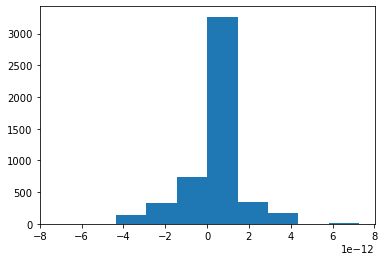

In [92]:
plt.hist(data_u2['hat_u2_unaware'] - data_u2['hat_u2_aware'])

(array([   4.,   41.,  226.,  776., 1493., 1429.,  793.,  198.,   37.,
           3.]),
 array([-4.03844184e+02, -3.23032054e+02, -2.42219925e+02, -1.61407796e+02,
        -8.05956668e+01,  2.16462415e-01,  8.10285916e+01,  1.61840721e+02,
         2.42652850e+02,  3.23464979e+02,  4.04277108e+02]),
 <BarContainer object of 10 artists>)

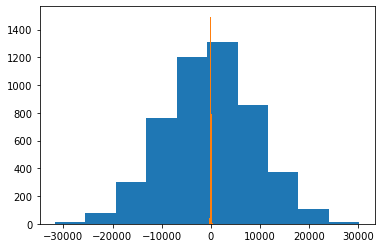

In [93]:
plt.hist(data_u2['hat_u2_unaware'])
plt.hist(data_u2['U2'])

(array([   4.,   41.,  226.,  776., 1493., 1429.,  793.,  198.,   37.,
           3.]),
 array([-4.03844184e+02, -3.23032054e+02, -2.42219925e+02, -1.61407796e+02,
        -8.05956668e+01,  2.16462415e-01,  8.10285916e+01,  1.61840721e+02,
         2.42652850e+02,  3.23464979e+02,  4.04277108e+02]),
 <BarContainer object of 10 artists>)

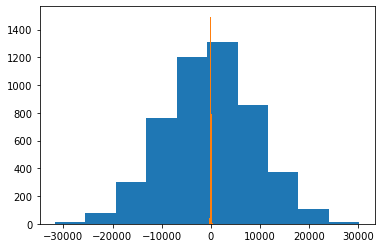

In [94]:
plt.hist(data_u2['hat_u2_aware'])
plt.hist(data_u2['U2'])

In [95]:
# store in data folder
data2.to_csv(data_path + '\\' + 'confounder_w.csv', sep='|', index=False)